In [1]:
import sys; sys.path.append('../..'); from wwa import *

# quick method for area-weighted averaging (will add to WWA main but need to generalise dims first)
def awmean(da): return da.weighted(np.cos(np.deg2rad(da.lat))).mean(["lat", "lon"])

# Detrended Nino3.4

Use monthly mean SST from 20S:20N to detrend [Nino3.4](https://climexp.knmi.nl/getindices.cgi?WMO=NCDCData/ersst_nino3.4a&STATION=NINO3.4&TYPE=i&id=someone@somewhere)

In [ ]:
# # download latest SST data from ERSST
# ! rm sst.mnmean.nc; wget https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc

rm: cannot remove 'sst.mnmean.nc': No such file or directory
--2024-03-11 14:13:00--  https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc
Resolving downloads.psl.noaa.gov (downloads.psl.noaa.gov)... 140.172.38.86
Connecting to downloads.psl.noaa.gov (downloads.psl.noaa.gov)|140.172.38.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110827429 (106M) [application/x-netcdf]
Saving to: ‘sst.mnmean.nc’

sst.mnmean.nc        32%[=====>              ]  34.22M  4.37MB/s    eta 15s    

In [3]:
ersst = wrap_lon(xr.open_dataset("sst.mnmean.nc").sst)

nino34 = awmean(ersst.sel(lat = slice(-5,5), lon = slice(-170,-120)))
sst_tropical = awmean(ersst.sel(lat = slice(-20,20)))

nino34_det = (nino34 - sst_tropical).rename("nino34")

nino34_det.to_netcdf("ersst_nino34_detrended.nc")

---
---
# Assorted research questions

## Is 2023-4 really a strong El Nino event?


In [31]:
ersst = wrap_lon(xr.open_dataset("sst.mnmean.nc").sst)

xn, xx, yn, yx = [-170,-120,-5,5]

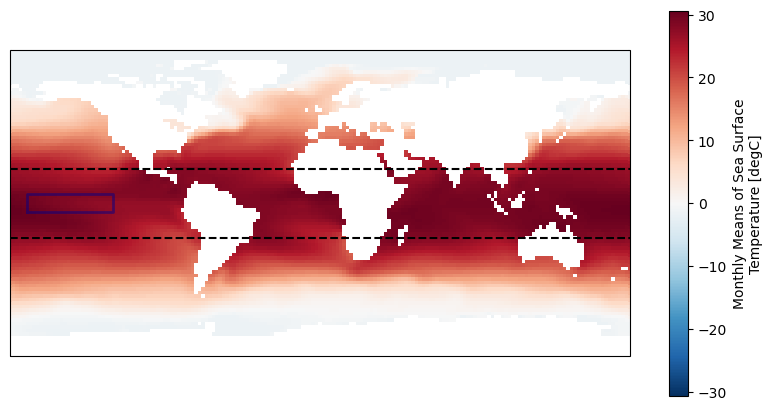

In [32]:
ersst.sel(time = slice("2023-12","2024-02")).mean("time").plot(figsize = (10,5), subplot_kws = {"projection" : cartopy.crs.PlateCarree()})
ax = plt.gca()

[ax.axhline(x, color = "k", ls = "--") for x in [-20,20]]
ax.plot([xn,xn,xx,xx,xn], [yn,yx,yx,yn,yn], color = "darkblue", lw = 2, alpha = 0.5)


In [9]:
gmst = pd.read_csv("igiss_al_gl_a_4yrlo.dat", comment = "#", sep = " +", header = None, names = ["year", "gmst"], index_col = 0, engine = "python")

In [ ]:
nino34.rename("nino34").to_dataframe().to_csv("nino34_monthly.csv")
sst_tropical.rename("sst_tropical").to_dataframe().to_csv("tropical-sst_monthly.csv")

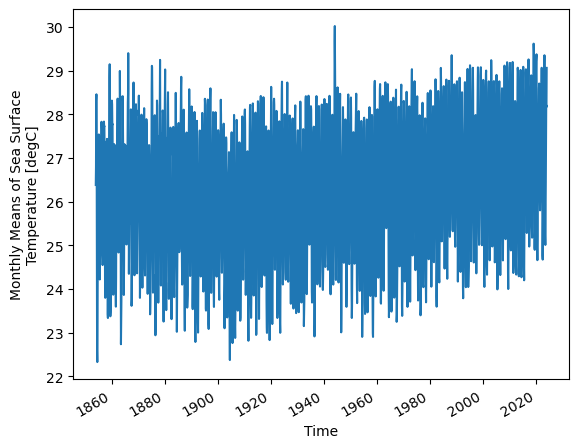

In [89]:
nino_atlantic = awmean(ersst.sel(lat = slice(-3,3), lon = slice(-20,0)))
nino_atlantic.plot()

In [88]:
nino_atlantic.rename("nino_atl").to_dataframe().to_csv("nino-atlantic.csv")

### Nino vs SOI

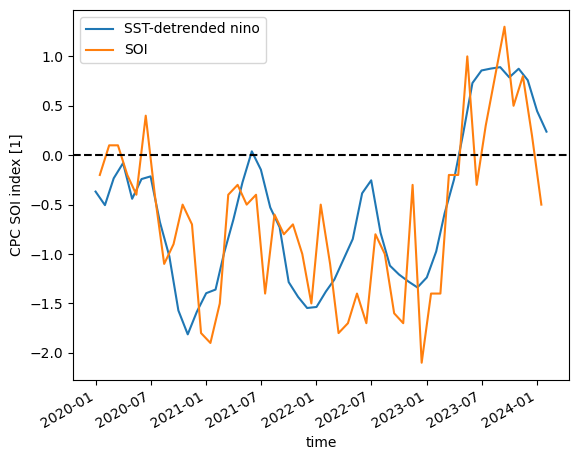

In [82]:
nino34 = nino34 - nino34.mean()
soi = -decode_times(xr.open_dataset("icpc_soi.nc", decode_times = False)).SOI.dropna("time", "any")
nino34_det.sel(time = slice("2020",None)).plot(label = "SST-detrended nino")

soi.sel(time = slice("2020",None)).plot(label = "SOI")
plt.axhline(0, ls = "--", color = "k")
plt.legend()

### Loess detrending

In [ ]:
df = pd.read_csv("nino-loess-smoothed.csv", index_col = "date", parse_dates = ["date"])
df_djf = df.rolling(3).mean().loc[df.month == 2]
df_djf.index = df_djf.index.year-1
df_djf = df_djf.dropna(axis = 0, how = "all")

In [64]:
df_djf[["nino_res"]].rename(columns = {"nino_res" : "nino"}).to_csv("nino-djf_loess-detrended.csv")

## AMO

Sometimes defined as the SST averaged over 0°-60°N, 0°-80°W minus SST averaged over 60°S-60°N

Can also be defined as the SST averaged over 25°-60°N, 7°-70°W minus the regression on global mean temperature

In [47]:
ersst = wrap_lon(xr.open_dataset("sst.mnmean.nc").sst)

amo_v1 = awmean(ersst.sel(lat = slice(0,60), lon = slice(0,80))) - awmean(ersst.sel(lat = slice(-60,60)))

---
# Original code using Climate Explorer

## Check how Nino34_rel is computed

Use monthly mean SST from 20S:20N to detrend [Nino3.4](https://climexp.knmi.nl/getindices.cgi?WMO=NCDCData/ersst_nino3.4a&STATION=NINO3.4&TYPE=i&id=someone@somewhere) (both ERSST)  

In [12]:
nino34 = decode_times(xr.open_dataset("iersst_nino3.4a.nc", decode_times = False))["Nino3.4"]
sst = decode_times(xr.open_dataset("iersstv5_0-360E_-20-20N_n_su.nc", decode_times = False))["sst"]
sst_anom = sst - sst.mean()
nino34_det = nino34 - sst_anom

In [10]:
nino34_rel = decode_times(xr.open_dataset("iersst_nino3.4a_rel.nc", decode_times = False))["Nino3.4r"]
m_adj = [1.2571,1.2948,1.3355,1.3746,1.3167,1.2179,1.1565,1.1505,1.1678,1.1909,1.2127,1.2350]
m_mean = sst_anom.sel(time = slice("1980", "2010")).groupby("time.month").mean()

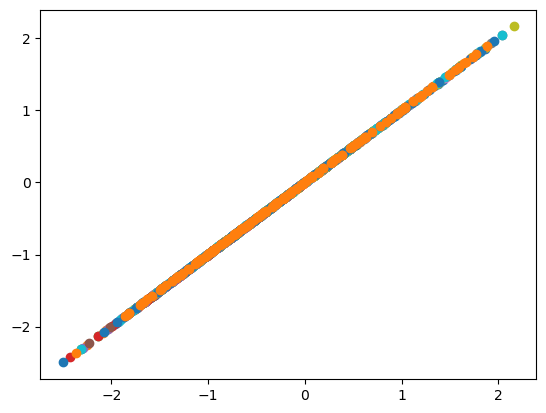

In [11]:
# check against Nino3.4rel:
for m in range(12):
    plt.scatter(nino34_det.groupby("time.month")[m+1], nino34_rel.groupby("time.month")[m+1] / m_adj[m] - m_mean.sel(month = m+1))

In [12]:
# save everything as .csv for easier transfer to R
nino34.to_pandas().to_csv("nino34.csv")
sst_anom.to_pandas().to_csv("sst_anom.csv")
nino34_det.to_pandas().to_csv("nino34_det.csv")
nino34_rel.to_pandas().to_csv("nino34_rel.csv")

## How is the scaling factor derived?

On the scaling factor used:  
`A technical point is that this index will have a 20% smaller variability than the original Niño3.4 index, as a large part of the interannual variability of the 20∘ S–20∘ N series is also ENSO-driven. This is not acceptable for users who rely on fixed categorical thresholds to define events, such as the NOAA thresholds of ±0.5$^\circ$C. In addition, statistical models that use the Niño3.4 index would need refitting. We therefore propose to renormalize the series to the same variability as the original Niño3.4 series by multiplying by 1/(1 − A) with A the regression of the 20∘ S–20∘ N SST anomalies on the Niño3.4 index after taking year-on-year differences to isolate the ENSO signal. The regression has a strong seasonal cycle, so it is determined for each month separately (averaging over the two adjoining months in the fit to increase the signal/noise ratio`

Still not quite sure what this means in practice - however, when using Nino3.4 as a covariate in a linear model, the difference in variability will be absorbed into the fitted coefficient, so this step shouldn't matter.

---
# AMO

## One way

The AMO index as defined as the SST averaged over 0°-60°N, 0°-80°W minus SST averaged over 60°S-60°N. The green line denotes a 10-yr running mean.

In [74]:
sst1 = decode_times(xr.open_dataset("iersstv5_-80-0E_0-60N_n_su.nc", decode_times = False)).sst
sst2 = decode_times(xr.open_dataset("iersstv5_0-360E_-60-60N_n_su.nc", decode_times = False)).sst

In [75]:
amo_v1 = sst1 - sst2

In [76]:
amo_feb = amo_v1.rolling(time = 12, min_periods = 11).mean().groupby("time.month")[2]
amo_feb = amo_feb.assign_coords(time = amo_feb.time.dt.year).rename(time = "year").dropna("year", "any")
amo_feb.to_dataframe().to_csv("amo.csv")

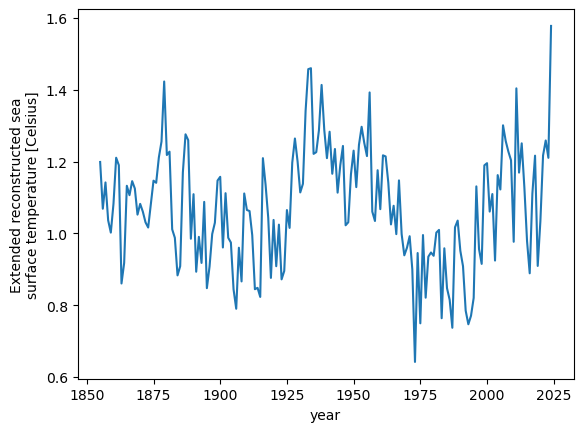

In [77]:
amo_feb.plot()

## And another

The AMO index as defined as the SST averaged over 25°-60°N, 7°-70°W minus the regression on global mean temperature. The green line denotes a 10-yr running mean.

In [42]:
import numpy as np
import statsmodels.api as sm

In [ ]:
ds = xr.merge([decode_times(xr.open_dataset("iersstv5_-70--7E_25-60N_n_su.nc", decode_times = False)).sst, 
               decode_times(xr.open_dataset("igiss_al_gl_m.nc", decode_times = False)).Ta.dropna("time", "any")]).dropna("time", "any")

lm = sm.OLS(ds.sst.values, sm.add_constant(ds.Ta.values))
mfit = (lm.fit()).fittedvalues
amo_v2 = ds.sst - mfit

amo_feb = amo_v2.rolling(time = 12, min_periods = 11).mean().groupby("time.month")[2]
amo_feb = amo_feb.assign_coords(time = amo_feb.time.dt.year).rename(time = "year").dropna("year", "any")
amo_feb.to_dataframe().to_csv("amo_detrended.csv")

In [ ]:
amo_df = xr.merge([amo_v1.rename("v1"), amo_v2.rename("v2")]).dropna("time", "any")
amo_df = amo_df - amo_df.mean()

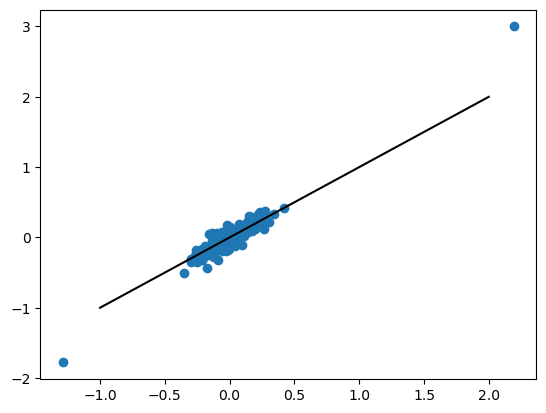

In [115]:
plt.scatter(amo_df.resample(time = "AS-JUL", skipna = True).mean().v1,
            amo_df.resample(time = "AS-JUL", skipna = True).mean().v2)
plt.plot((-1,2), (-1,2), color = "k")

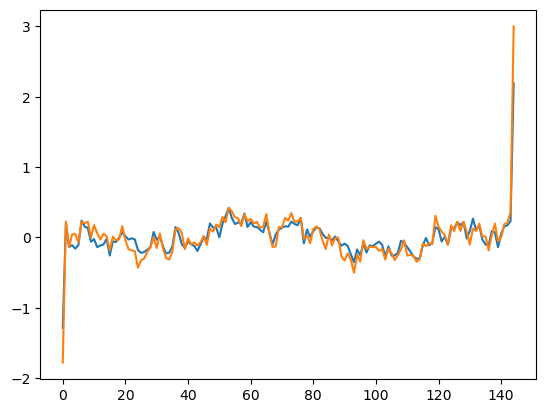

In [103]:
plt.plot(amo_df.v1.resample(time = "AS-JUL", skipna = True).mean())
plt.plot(amo_df.v2.resample(time = "AS-JUL", skipna = True).mean(skipna = True))

In [105]:
amo_df

<xarray.Dataset>
Dimensions:  (time: 1727)
Coordinates:
  * time     (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2023-11-15
Data variables:
    v1       (time) float32 -1.417 -2.011 -2.105 -1.761 ... 2.869 2.116 0.8366
    v2       (time) float64 -2.028 -2.643 -2.866 -2.35 ... 3.992 2.442 0.3586